**Periodic Potential**

$V_{c}(x,y)=-V_{0}exp(-(\alpha_{x} \frac{(x-x_{0})^{2}}{a^{2}} + \alpha_{y} \frac{(y-y_{0})^{2}}{a^{2}}))$

where $V_{0}$ represents the maximum depth of the potential well, $a$ is the length of the unit cell,

$(x_{0}, y_{0})$ are the coordinates of the center of the potential well

------------

In the example, $a = 4$ a.u., $V_{0} = 3 \pi^2 / 2a^2, \alpha_{x}=\alpha_{y}=6.5$, $x_{0}/y_{0}$ is distributed every 4 unit in the range $[-8,8] \times [-8,8]$

$V(x, y) = \sum_{n} -V_{0}exp(-(\alpha_{x} \frac{(x-x_{n})^{2}}{a^{2}} + \alpha_{y} \frac{(y-y_{n})^{2}}{a^{2}}))$

To ensure positive, add 1:

$\rightarrow V(x, y) = \sum_{n} 1-\frac{3 \pi^2}{32}exp(-(6.5 \frac{(x-x_{n})^{2}}{16} + 6.5  \frac{(y-y_{n})^{2}}{16}))$


In [89]:
from HMC import HMC
import sys
sys.path.append("..")
from MCMC_DZ.MCMC.Statistic_tools import auto_corr_plot, targetDis_step_plot, densities_plot

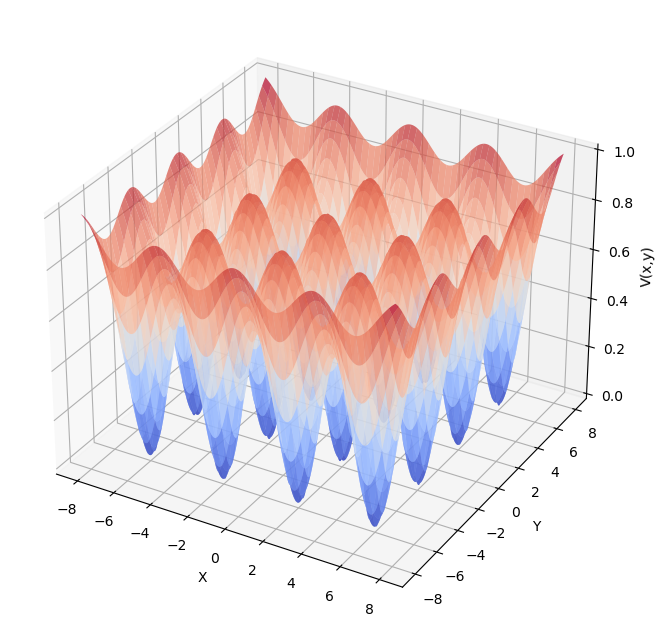

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import poisson

# Define the parameters.
a = 4.0
V0 = 3 * np.pi**2 / (2 * a**2)
alpha_x = alpha_y = 6.5

# Define the potential function.
def V(x, y, xn, yn, alpha_x=alpha_x, alpha_y=alpha_y):
    return 1-V0 * np.exp(-(alpha_x * (x - xn)**2 / a**2 + alpha_y * (y - yn)**2 / a**2))

# Define a grid of points.
N = 10000
x = np.linspace(-8, 8, N)
y = np.linspace(-8, 8, N)
X, Y = np.meshgrid(x, y)

# Define the centers of the potential wells.
centers = [(i, j) for i in range(-6, 7, 4) for j in range(-6, 7, 4)]

# Compute the total potential at each point.
Z = np.zeros_like(X)
for xn, yn in centers:
    Z += V(X, Y, xn, yn)

V_normalized = Z/np.sum(Z)
Z_scaled = (Z-np.min(Z))/(np.max(Z)-np.min(Z))

# Plot the potential.
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_scaled, alpha=0.7, cmap='coolwarm')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('V(x,y)')
plt.show()

In [57]:
# First, flatten V and create an array of corresponding indices
V_flat = V_normalized.flatten()
indices = np.arange(V_flat.size)

# Generate data indices according to the distribution V_flat
data_indices = np.random.choice(indices, size=N, p=V_flat)

# Convert these indices back to 2D coordinates
data_coordinates = np.unravel_index(data_indices, V_normalized.shape)

# At this point, data_coordinates is a tuple of two arrays, representing the x and y coordinates of the data points
# If you need these as an array of (x, y) pairs, you can use:
# data_points = np.vstack(data_coordinates).T

In [58]:
data = (x[data_coordinates[0]],y[data_coordinates[1]])
data = np.squeeze(data).T

In [59]:
from typing import List


def generate_noisy_data_2d(data, bins=int, noise_scale: float=None):
    '''
    Generate data with Poisson flucuations
    
    Arguments
    data [np.ndarra]: initial dataset
    bins: number of bins for the poisson fluctuation
    noise_scale: standard deviation of the Poisson noise
    
    Returns 
    noise_data [float or None]: data with the Poisson noise added
    
    '''
    n_dimensions = 2
    # first create a numpy histogram
    data_hist, bin_edges = np.histogramdd(data, bins=bins)
    bin_centers = []
    for i in range(n_dimensions):
        bin_centers.append((bin_edges[i][:-1] + bin_edges[i][1:]) / 2.0)

    # Calculate the bin areas (assuming uniform bins)
    bin_areas = np.ones_like(data_hist)
    for i in range(n_dimensions):
        bin_areas *= (bin_edges[i][1:] - bin_edges[i][:-1]).reshape([-1 if j == i else 1 for j in range(n_dimensions)])

    # Calculate expected number of events per bin and add Poisson noise
    expected_values = data_hist * bin_areas
    noisy_data_hist = poisson.rvs(expected_values)

     # create the noisy data set with same size as original data
    noisy_data = np.empty_like(data)

    for i in range(n_dimensions):
        noisy_data[:, i] = np.random.choice(bin_centers[i], size=data.shape[0], p=sum(noisy_data_hist / noisy_data_hist.sum()))

    if noise_scale is not None:
        noisy_data = noisy_data + np.random.normal(scale=noise_scale, size=noisy_data.shape)

    return noisy_data

In [61]:
noisy_data = generate_noisy_data_2d(data=data,bins=30)

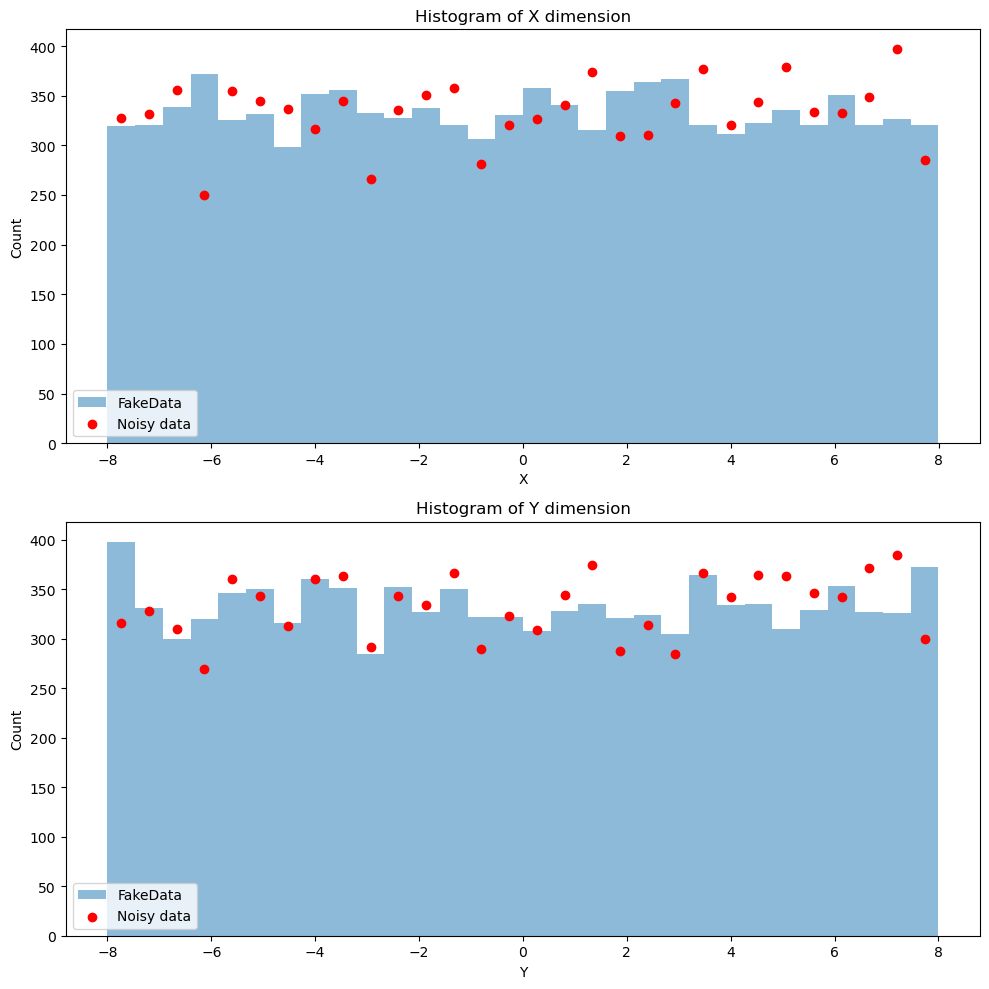

In [68]:
import matplotlib.pyplot as plt

# Extract the x and y dimensions from the noisy data
# x_data = data[:,0]
# y_data = data[:,1]

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot the histogram for the x dimension

for i in range(2):
    data_counts, data_edges = np.histogram(data[:,i], bins=30)
    data_bin_centers = (data_edges[:-1] + data_edges[1:]) / 2.0
    noisy_counts, noisy_edges = np.histogram(noisy_data[:,i], bins=30)
    noisy_bin_centers = (noisy_edges[:-1] + noisy_edges[1:]) / 2.0
    data_bars = axs[i].bar(data_bin_centers, data_counts, alpha=0.5, label='FakeData', width=(data_bin_centers[1] - data_bin_centers[0]))
    noisy_points = axs[i].scatter(data_bin_centers, noisy_counts, color='red', label='Noisy data')
    handles = [data_bars, noisy_points]
    if i == 0:
        axs[i].set_title('Histogram of X dimension')
        axs[i].set_xlabel('X')
        axs[i].set_ylabel('Count')
        axs[i].legend(handles=handles,loc=3)
    if i == 1:
        axs[i].set_title('Histogram of Y dimension')
        axs[i].set_xlabel('Y')
        axs[i].set_ylabel('Count')
        axs[i].legend(handles=handles,loc=3)

# Display the figure
plt.tight_layout()
plt.show()


In [79]:
def log_likelihood(x, y, mcx, mcy, alphax, alphay, xn=xn, yn=yn):
    lambda_ = V(x, y, xn, yn, alphax, alphay)
    data = V(mcx, mcy, xn, yn, alphax, alphay)
    return -(lambda_ - data + data * np.log(data/lambda_))

def log_likelihoods(params):
    alpha_x, alpha_y = params
    return np.sum(log_likelihood(x=data[:,0], y=data[:,1], mcx=noisy_data[:,0], mcy=noisy_data[:,1], alphax=alpha_x, alphay=alpha_y))

In [81]:
def dfdx(mu):
    '''
    Forward differencing scheme
    '''
    epsilon = 0.01
    n_dims = 1
    n_comp = 1
    mu = np.array(mu)
    delta_theta = []
    res_mu_plus = []
    for i in range(mu.shape[0]):
        E_plus = np.zeros(n_dims*n_comp)
        E_plus += [(epsilon if j == i else 0) for j in range(n_dims*n_comp)]
        res_mu_plus.append(E_plus)

    for i in range(n_dims*n_comp):
        delta_thetai = (log_likelihoods(mu+res_mu_plus[i]) - log_likelihoods(mu))/(epsilon)
        delta_theta.append(delta_thetai)
        
    return delta_theta

In [82]:
def U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the potential energy function: 
    U(theta) = -log(probability distribution of theta)
    '''
    return - log_likelihoods(theta)

def grad_U(theta: List[np.longdouble]) -> np.longdouble:
    '''
    the derivative of the potential energy function
    dU/dmu
    '''
    DRho = dfdx(theta)
    Rho = - log_likelihoods(theta)
    return np.array([dRho/Rho for dRho in DRho])

In [85]:
theta_accept, theta_reject = HMC(epoch=2000, L=20, epsilon=0.01, U=U, grad_U=grad_U, current_theta=np.array([1,1]))

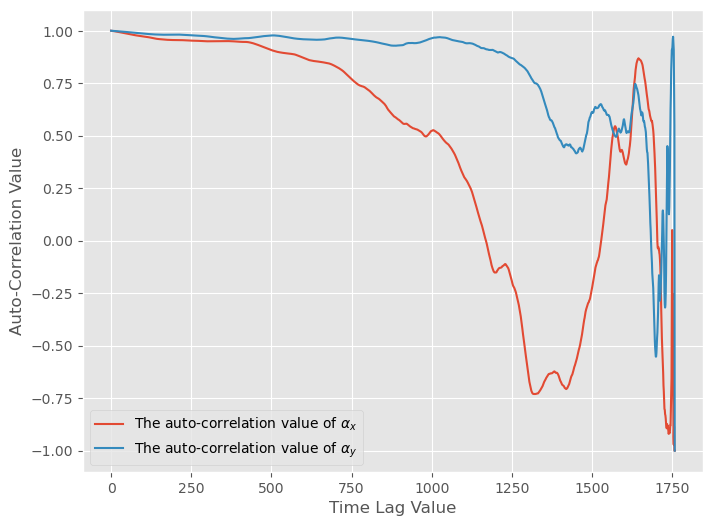

In [95]:
auto_corr_plot(theta_accept, plot_nth_theta=[0,1],theta_index=['$\\alpha_{x}$','$\\alpha_{y}$'],max_time_lag=len(theta_accept),figsize=[8,6])

In [97]:
alphax = np.linspace(1, 10, N)
alphay = np.linspace(1, 10, N)
alphaX, alphaY = np.meshgrid(alphax, alphay)

